In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

# use the CAMB cosmology that generated the matter power spectra
import camb
from cosmology import Cosmology

# GLASS modules: cosmology and everything in the glass namespace
import glass.shells
import glass.fields
import glass.points
import glass.shapes
import glass.lensing
import glass.galaxies
import glass.observations
import glass.ext.camb


# cosmology for the simulation
h = 0.7
Oc = 0.25
Ob = 0.05

# basic parameters of the simulation
nside = lmax = 256

# set up CAMB parameters for matter angular power spectrum
pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2,
                       NonLinear=camb.model.NonLinear_both)

# get the cosmology from CAMB
cosmo = Cosmology.from_camb(pars)

In [2]:
# shells of 200 Mpc in comoving distance spacing
zb = glass.shells.distance_grid(cosmo, 0., 3., dx=200.)

# tophat window functions for shells
ws = glass.shells.tophat_windows(zb)

# compute the angular matter power spectra of the shells with CAMB
cls = glass.ext.camb.matter_cls(pars, lmax, ws)

# compute Gaussian cls for lognormal fields for 3 correlated shells
# putting nside here means that the HEALPix pixel window function is applied
gls = glass.fields.lognormal_gls(cls, nside=nside, lmax=lmax, ncorr=3)

# generator for lognormal matter fields
matter = glass.fields.generate_lognormal(gls, nside, ncorr=3)


In [3]:
# this will compute the convergence field iteratively
convergence = glass.lensing.MultiPlaneConvergence(cosmo)

In [4]:
# galaxy density (using 1/100 of the expected galaxy number density for Stage-IV)
n_arcmin2 = 0.3

# true redshift distribution following a Smail distribution
z = np.arange(0., 3., 0.01)
dndz = glass.observations.smail_nz(z, z_mode=0.9, alpha=2., beta=1.5)
dndz *= n_arcmin2

# compute tomographic redshift bin edges with equal density
nbins = 10
zbins = glass.observations.equal_dens_zbins(z, dndz, nbins=nbins)

# photometric redshift error
sigma_z0 = 0.03

# constant bias parameter for all shells
bias = 1.2

# ellipticity standard deviation as expected for a Stage-IV survey
sigma_e = 0.27

Here, `vis` is a fractional detection map, not a magnitude map. We need to convert between the map to this somehow.

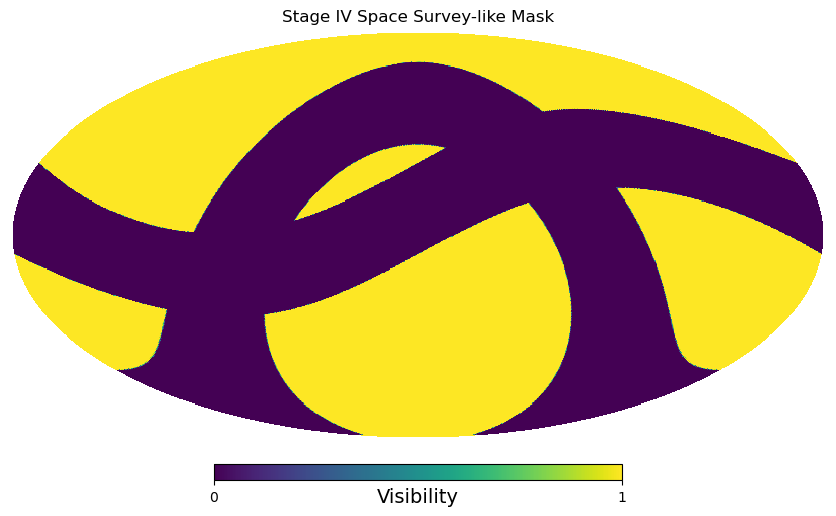

In [5]:
vis = glass.observations.vmap_galactic_ecliptic(nside)

# checking the mask:
hp.mollview(vis, title='Stage IV Space Survey-like Mask', unit='Visibility')
plt.show()


In [58]:
n = (5 * (sigma_e ** 2)) + 8
d = 2- (4 * sigma_e ** 2)

In [59]:
np.sqrt(n/d)

2.2127136316176816

In [76]:
# testing, not part of main setup
gal_eps_g = glass.shapes.ellipticity_intnorm(100000, sigma_e)

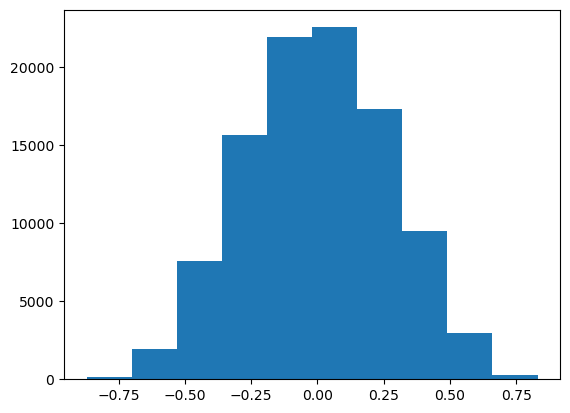

In [77]:
plt.hist(np.real(gal_eps_g))
plt.show()

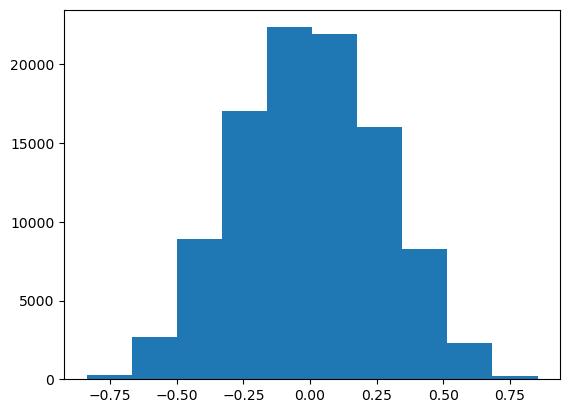

In [78]:
plt.hist(np.imag(gal_eps_g))
plt.show()

In [79]:
np.real(gal_eps_g).mean(), np.real(gal_eps_g).std()

(0.0001496541789803778, 0.2699223097848981)

In [80]:
np.imag(gal_eps_g).mean(), np.imag(gal_eps_g).std()

(-0.0002606186879570888, 0.27027851029468797)

In [81]:
# testing, not part of main setup
gal_eps = glass.shapes.ellipticity_gaussian(100000, sigma_e)

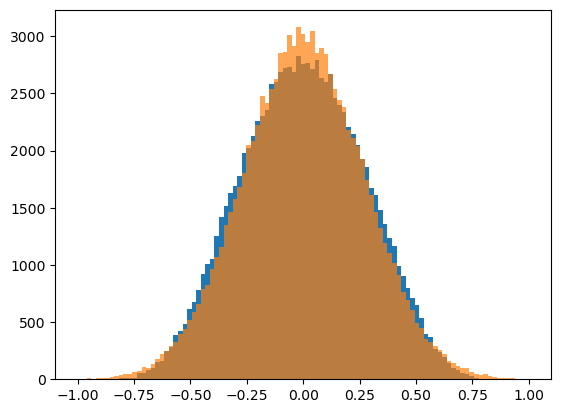

In [86]:
bins = np.linspace(-1, 1, 100)
plt.hist(np.real(gal_eps_g), bins = bins, label = 'intnorm')
plt.hist(np.real(gal_eps), bins = bins, alpha = 0.7, label = 'gaussian')
plt.show()

In [52]:
glass.shapes.ellipticity_gaussian??

Signature:
glass.shapes.ellipticity_gaussian(
    count: 'int | ArrayLike',
    sigma: 'ArrayLike',
    *,
    rng: 'np.random.Generator | None' = None,
) -> 'NDArray'
Source:   
def ellipticity_gaussian(count: int | ArrayLike, sigma: ArrayLike, *,
                         rng: np.random.Generator | None = None
                         ) -> NDArray:
    r'''Sample Gaussian galaxy ellipticities.

    The ellipticities are sampled from a normal distribution with
    standard deviation ``sigma`` for each component.  Samples where the
    ellipticity is larger than unity are discarded.  Hence, do not use
    this function with too large values of ``sigma``, or the sampling
    will become inefficient.

    Parameters
    ----------
    count : int or array_like
        Number of ellipticities to be sampled.
    sigma : array_like
        Standard deviation in each component.
    rng : :class:`~numpy.random.Generator`, optional
        Random number generator.  If not given, a default RNG i

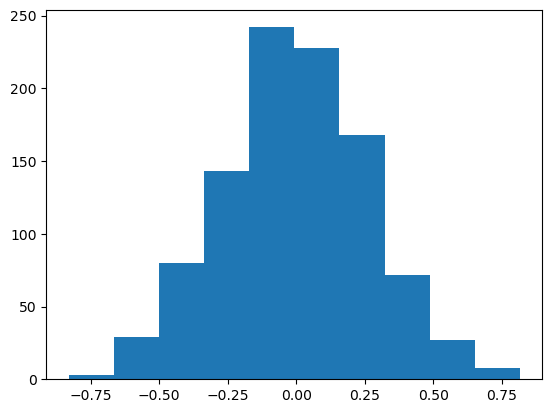

In [25]:
plt.hist(np.imag(gal_eps))
plt.show()

In [22]:
np.real(gal_eps).mean(), np.real(gal_eps).std()

(0.006332524249376603, 0.2667206509892329)

In [23]:
np.imag(gal_eps).mean(), np.imag(gal_eps).std()

(-0.0015266075089241742, 0.26677561619424145)

In [6]:
# we will store the catalogue as a structured numpy array, initially empty
catalogue = np.empty(0, dtype=[('RA', float), ('DEC', float),
                               ('Z_TRUE', float), ('PHZ', float), ('ZBIN', int),
                               ('G1', float), ('G2', float)])

# simulate the matter fields in the main loop, and build up the catalogue
for i, delta_i in enumerate(matter):

    # compute the lensing maps for this shell
    convergence.add_window(delta_i, ws[i])
    kappa_i = convergence.kappa
    gamm1_i, gamm2_i = glass.lensing.shear_from_convergence(kappa_i)

    # the true galaxy distribution in this shell
    z_i, dndz_i = glass.shells.restrict(z, dndz, ws[i])

    # integrate dndz to get the total galaxy density in this shell
    ngal = np.trapz(dndz_i, z_i)

    # generate galaxy positions from the matter density contrast
    for gal_lon, gal_lat, gal_count in glass.points.positions_from_delta(ngal, delta_i, bias, vis):

        # generate random redshifts from the provided nz
        gal_z = glass.galaxies.redshifts_from_nz(gal_count, z_i, dndz_i)

        # generator photometric redshifts using a Gaussian model
        gal_phz = glass.galaxies.gaussian_phz(gal_z, sigma_z0)

        # attach tomographic bin IDs to galaxies, based on photometric redshifts
        gal_zbin = np.digitize(gal_phz, np.unique(zbins)) - 1

        # generate galaxy ellipticities from the chosen distribution
        gal_eps = glass.shapes.ellipticity_intnorm(gal_count, sigma_e)

        # apply the shear fields to the ellipticities
        gal_she = glass.galaxies.galaxy_shear(gal_lon, gal_lat, gal_eps,
                                              kappa_i, gamm1_i, gamm2_i)

        # make a mini-catalogue for the new rows
        rows = np.empty(gal_count, dtype=catalogue.dtype)
        rows['RA'] = gal_lon
        rows['DEC'] = gal_lat
        rows['Z_TRUE'] = gal_z
        rows['PHZ'] = gal_phz
        rows['ZBIN'] = gal_zbin
        rows['G1'] = gal_she.real
        rows['G2'] = gal_she.imag

        # add the new rows to the catalogue
        catalogue = np.append(catalogue, rows)

print(f'Total number of galaxies sampled: {len(catalogue):,}')

Total number of galaxies sampled: 22,290,859


In [8]:
glass.points.positions_from_delta??

Signature:
glass.points.positions_from_delta(
    ngal,
    delta,
    bias=None,
    vis=None,
    *,
    bias_model='linear',
    remove_monopole=False,
    batch=1000000,
    rng=None,
)
Source:   
def positions_from_delta(ngal, delta, bias=None, vis=None, *,
                         bias_model='linear', remove_monopole=False,
                         batch=1_000_000, rng=None):
    '''Generate positions tracing a density contrast.

    The map of expected number counts is constructed from the number
    density, density contrast, an optional bias model, and an optional
    visibility map.

    If ``remove_monopole`` is set, the monopole of the computed density
    contrast is removed.  Over the full sky, the mean number density of
    the map will then match the given number density exactly.  This,
    however, means that an effectively different bias model is being
    used, unless the monopole is already zero in the first place.

    The function supports multi-dimensional input 

In [10]:
glass.shapes.ellipticity_intnorm?

Signature:
glass.shapes.ellipticity_intnorm(
    count: 'int | ArrayLike',
    sigma: 'ArrayLike',
    *,
    rng: 'np.random.Generator | None' = None,
) -> 'NDArray'
Docstring:
Sample galaxy ellipticities with intrinsic normal distribution.

The ellipticities are sampled from an intrinsic normal distribution
with standard deviation ``sigma`` for each component.

Parameters
----------
count : int | array_like
    Number of ellipticities to sample.
sigma : array_like
    Standard deviation of the ellipticity in each component.
rng : :class:`~numpy.random.Generator`, optional
    Random number generator.  If not given, a default RNG is used.

Returns
-------
eps : array_like
    Array of galaxy :term:`ellipticity`.
File:      /project/chihway/envs/glass/lib/python3.11/site-packages/glass/shapes.py
Type:      function

In [11]:
glass.galaxies.galaxy_shear?

Signature:
glass.galaxies.galaxy_shear(
    lon: 'np.ndarray',
    lat: 'np.ndarray',
    eps: 'np.ndarray',
    kappa: 'np.ndarray',
    gamma1: 'np.ndarray',
    gamma2: 'np.ndarray',
    *,
    reduced_shear: 'bool' = True,
) -> 'np.ndarray'
Docstring:
Observed galaxy shears from weak lensing.

Takes lensing maps for convergence and shear and produces a lensed
ellipticity (shear) for each intrinsic galaxy ellipticity.

Parameters
----------
lon, lat : array_like
    Arrays for galaxy longitudes and latitudes.
eps : array_like
    Array of galaxy :term:`ellipticity`.
kappa, gamma1, gamma2 : array_like
    HEALPix maps for convergence and two components of shear.
reduced_shear : bool, optional
    If ``False``, galaxy shears are not reduced by the convergence.
    Default is ``True``.

Returns
-------
she : array_like
    Array of complex-valued observed galaxy shears (lensed ellipticities).
File:      /project/chihway/envs/glass/lib/python3.11/site-packages/glass/galaxies.py
Type:   

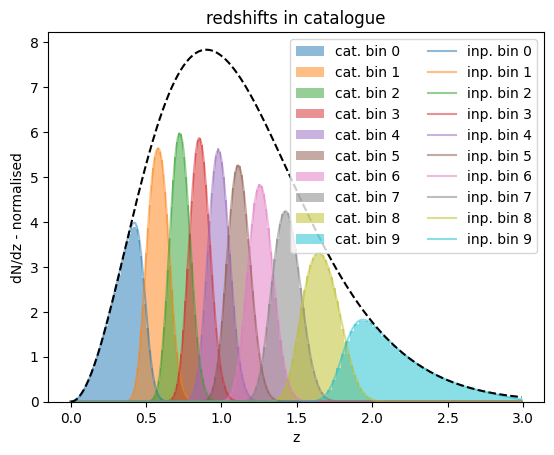

In [7]:
# split dndz using the same Gaussian error model assumed in the sampling
tomo_nz = glass.observations.tomo_nz_gausserr(z, dndz, sigma_z0, zbins)

# redshift distribution of tomographic bins & input distributions
plt.figure()
plt.title('redshifts in catalogue')
plt.ylabel('dN/dz - normalised')
plt.xlabel('z')
for i in range(nbins):
    in_bin = (catalogue['ZBIN'] == i)
    plt.hist(catalogue['Z_TRUE'][in_bin], histtype='stepfilled', edgecolor='none', alpha=0.5, bins=50, density=1, label=f'cat. bin {i}')
for i in range(nbins):
    plt.plot(z, (tomo_nz[i]/n_arcmin2)*nbins, alpha=0.5, label=f'inp. bin {i}')
plt.plot(z, dndz/n_arcmin2*nbins, ls='--', c='k')
plt.legend(ncol=2)
plt.show()
